# To Do
Clean Folium map
Plot price/grade/condition/other features in top and bottom zipcodes
Reverse log for MAE and RSME $s

# Summary

## Business Problem:
COVID has brought interest rates super low and home buying has skyrocketed.
First time homebuyer needs to find what they can get within their budget in their area of interest

Like Zillow filters - needs to be able understand which areas and how many beds/bath other features impact price, fixer upper vs higher grade/condition (coefficients)


What is going to drive the price up, what they you sacrifice versusprioritize to get closest to their price range

## Data Cleansing:

#### Nulls:
- Filled nulls for waterfront, view

#### Converted:
- date from string to datetime
- yr_renovated from float to int

#### Calculated:
- sqft_basement from sqft_living and sqft_above since sqft_basement had nulls and sqft_living and sqft_above did notnorma

#### Dropped:
- view as it is not a feature of the home; not useful for business case

## Feature Engineering:

#### Feature 1

- Created: has_basement (Boolean)
- Dropped: sqft_basement

#### Feature 2

- Created: has_been_renovated (Boolean)
- Dropped: yr_renovated

#### Feature 3

- Created: age (in years)
- Dropped: yr_built

## Functions:

#### correlation_view

#### high_corr

#### model_scores

#### model_scores_stanscale


## Models:
**Models with biggest impact italicized**

#### Phase 1: First Models and Editing Data for Business Case_

1\. Nothing But Data Cleanse - 69/68

2\. Pared down locations - 69/69

#### Phase 2: Addressing Highly Correlated Xs and Feature Engineering

3\. Model without sqft_above 67/68

4\. New Features and Booleans 67/68

5\. Testing without sqft_lot15 67/68

6\. Testing without sqft_living15 65/66

#### Phase 3: Log Transforms and OHE

**_7\. Post Log-Transform 69/70_**

8\. Testing without has_basement 69/70

**_9\. OHE zipcode 83/83_**

## Recommendations:

#### Area
- Home buyers should look into Bothell at first (middle of the road as far as price influence) and 30-40 minutes by public transit or car to central Seattle (Pikes Place), 45% of residents have higher education (Bachelors+)
(Source: https://www.unitedstateszipcodes.org/98011/)
- If area is important and have more budget, Medina, Bellevue, and parts of Seattle (Mann, Central Area, Westlake, Eastlake, Cascade)
- Kent and Auburn as they are highest negative influencers of price
- Kent has high crime rates: https://www.seattletimes.com/seattle-news/crime/is-seattle-safe-you-might-be-better-off-in-snoqualmie-or-sunnyside/

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns

# For data cleansing
from datetime import datetime

# For mapping
import folium

# Import statsmodels
import statsmodels.api as sm

# Import scikit learn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
# Import data
data = pd.read_csv('../data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Overview of data types and completeness of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

# Data Cleansing

In [4]:
# Convert date from string to datetime; Reassign Series to be in date time format
data['date'] = pd.to_datetime(data['date'],format='%m/%d/%Y')

In [5]:
# Waterfront nulls - Fillna with 0 -- assume no waterfront for null values
data['waterfront'] = data['waterfront'].fillna(0.0)

In [6]:
# Views nulls - Fillna with 0. Assume if null, 0 views
data['view'].fillna(0.0, inplace=True)

In [7]:
# Convert sqft_basement to numerical, found '?' value, replace with null
data['sqft_basement'] = data['sqft_basement'].str.replace('?','')

# Fill nulls with using sqft_living and sqft_above that have no nulls
for row in data['sqft_basement'].index:
    data['sqft_basement'][row] = data['sqft_living'][row] - data['sqft_above'][row]

<ipython-input-7-2ee42db9c23c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sqft_basement'][row] = data['sqft_living'][row] - data['sqft_above'][row]


In [8]:
# yr_renovated nulls - Fill nulls with 0.0 as others are, assume no renovation if null
data['yr_renovated'] = data['yr_renovated'].fillna(0.0)

# Convert yr_renovated to int for cleansing and to match yr_built
data['yr_renovated'] = data['yr_renovated'].astype(int)

In [9]:
# Drop view, number of times house has been viewed is not a home feature
data = data.drop(labels='view', axis=1)

# Correlation check

In [10]:
def correlation_view(df, annot):
    """Create correlation triangle (lower half only) from given data frame"""
    # From Seaborn documentation - https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=annot)

In [11]:
def high_corr(thresh, df):
    """Given a correlation threshold and DataFrame, will return a DataFrame of 
    feature correlations above the threshold"""
    corr_val=thresh
    df2 = df.corr().unstack().reset_index()
    high_corr = df2[(df2[0]>corr_val)& (df2[0]<1)]
    return high_corr

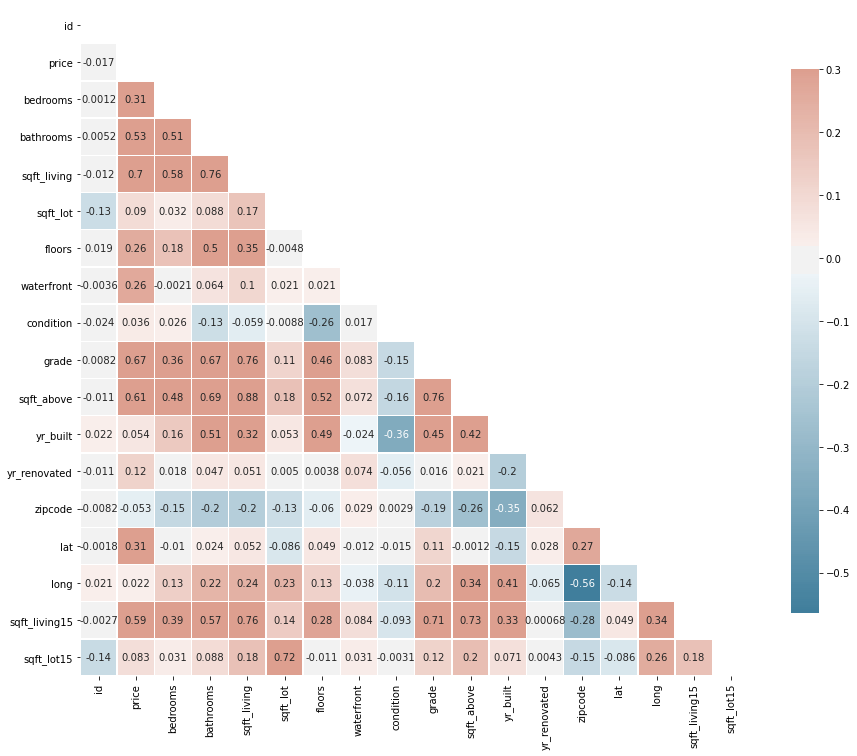

In [12]:
correlation_view(data, annot=True)

In [13]:
data.corr().price.sort_values(ascending=False)
# Grade, sqft_living, sqft_above, sqft_living15, bathrooms are most correlated with price

price            1.000000
sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
bedrooms         0.308787
lat              0.306692
waterfront       0.264306
floors           0.256804
yr_renovated     0.117855
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
condition        0.036056
long             0.022036
id              -0.016772
zipcode         -0.053402
Name: price, dtype: float64

In [14]:
# Define function to obtain R2, MSE, and RMSE
def model_scores(data, remove, target, testsize):
    """ Given a dataset, a list of columns to not include in the model, the target variable, and testsize,
    this function returns Training and Test Scores including R2, MSE, and RMSE.
    It does this by defining X & Y, creating train_test_split with given testsize and incorporating randomstate=42 
    standard, instantiating LinearRegression, fitting training data, grabbing predictions for train and test set to 
    get final numbers. NOTE: Scaler not included.
    """
    # Define X and y
    X_cols = [c for c in data.columns.to_list() if c not in remove] 
    X = data[X_cols]
    y = data[target]
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=42)
    # Instantiate
    lr = LinearRegression()
    # Fit training data
    lr.fit(X_train, y_train)
    # Grab predictions for train and test set
    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)
    #Return Results
    print("Training Scores:")
    print(f"R2: {r2_score(y_train, y_pred_train)}") #can account for X amount of variance
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_pred_train)}") #about X amount off in predicting price
    print(f"Root Mean Squared Error: {np.sqrt(mean_absolute_error(y_train, y_pred_train))}")
    print("---")
    print("Testing Scores:")
    print(f"R2: {r2_score(y_test, y_pred_test)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_test)}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_absolute_error(y_test, y_pred_test))}")

In [15]:
# Define function to obtain R2, MSE, and RMSE
def model_scores_stanscale(data, remove, target, testsize):
    """ Given a dataset, a list of columns to not include in the model, the target variable, and testsize,
    this function returns Training and Test Scores including R2, MSE, and RMSE.
    It does this by defining X & Y, creating train_test_split with given testsize and incorporating randomstate=42 
    standard, instantiating LinearRegression, fitting training data, grabbing predictions for train and test set to 
    get final numbers. NOTE: Standard Scaler applied
    """
    # Define X and y
    X_cols = [c for c in data.columns.to_list() if c not in remove] 
    X = data[X_cols]
    y = data[target]
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=42)
    # Instantiate a new scaler to scale our data with Standard Scaler
    scaler = StandardScaler()
    # Train scaler on training data, then fit to testing
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Instantiate a linear regression model
    lr = LinearRegression()
    # Fit our model on our scaled data
    lr.fit(X_train_scaled, y_train)
    # Grab predictions for train and test set (scaled data)
    y_pred_train = lr.predict(X_train_scaled)
    y_pred_test = lr.predict(X_test_scaled)
    #Return Results
    print("Training Scores:")
    print(f"R2: {r2_score(y_train, y_pred_train)}") #can account for X amount of variance
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_pred_train)}") #about X amount off in predicting price
    print(f"Root Mean Squared Error: {np.sqrt(mean_absolute_error(y_train, y_pred_train))}")
    print("---")
    print("Testing Scores:")
    print(f"R2: {r2_score(y_test, y_pred_test)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_test)}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_absolute_error(y_test, y_pred_test))}")

# Model 1: Nothing But Data Cleanse

In [16]:
model_scores(data, remove=['price', 'date', 'id'], target =['price'], testsize=0.33)
# Training > Testing so slightly overfit

Training Scores:
R2: 0.6958287667302945
Mean Absolute Error: 129057.12940232246
Root Mean Squared Error: 359.24522182253514
---
Testing Scores:
R2: 0.6803311652783075
Mean Absolute Error: 128165.89039082723
Root Mean Squared Error: 358.002640200917


In [17]:
# # Stack Overflow: https://stackoverflow.com/questions/39401729/plot-latitude-longitude-points-from-dataframe-on-folium-map-ipython
# # Create a map
# this_map = folium.Map(prefer_canvas=True)

# def plotDot(point):
#     '''input: series that contains a numeric named latitude and a numeric named longitude
#     this function creates a CircleMarker and adds it to your this_map'''
#     folium.CircleMarker(location=[point.lat, point.long],
#                         radius=1,
#                         weight=1, popup=point.long).add_to(this_map)

# #use df.apply(,axis=1) to "iterate" through every row in your dataframe
# data.apply(plotDot, axis = 1)


# #Set the zoom to the maximum possible
# this_map.fit_bounds(this_map.get_bounds())


# this_map

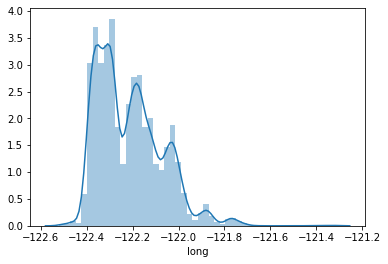

In [18]:
# Map showing outliers mostly in the east, look at distribution of longitude (east/west)
sns.distplot(data['long'])

In [19]:
# Different look at distribuion numbers. Can see max outlier
data['long'].describe()

count    21597.000000
mean      -122.213982
std          0.140724
min       -122.519000
25%       -122.328000
50%       -122.231000
75%       -122.125000
max       -121.315000
Name: long, dtype: float64

In [20]:
# Filter down data to 75% and remap
data_longzoom = data[data['long'] <= -122.125]

In [21]:
# Cut out 25% of records, but should be better for model to have a more condensed space
data_longzoom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16214 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             16214 non-null  int64         
 1   date           16214 non-null  datetime64[ns]
 2   price          16214 non-null  float64       
 3   bedrooms       16214 non-null  int64         
 4   bathrooms      16214 non-null  float64       
 5   sqft_living    16214 non-null  int64         
 6   sqft_lot       16214 non-null  int64         
 7   floors         16214 non-null  float64       
 8   waterfront     16214 non-null  float64       
 9   condition      16214 non-null  int64         
 10  grade          16214 non-null  int64         
 11  sqft_above     16214 non-null  int64         
 12  sqft_basement  16214 non-null  object        
 13  yr_built       16214 non-null  int64         
 14  yr_renovated   16214 non-null  int64         
 15  zipcode        1621

In [22]:
# # New map
# this_map_zoom = folium.Map(prefer_canvas=True)

# def plotDot(point):
#     '''input: series that contains a numeric named latitude and a numeric named longitude
#     this function creates a CircleMarker and adds it to your this_map'''
#     folium.CircleMarker(location=[point.lat, point.long],
#                         radius=1,
#                         weight=1, popup=point.long).add_to(this_map_zoom)

# #use df.apply(,axis=1) to "iterate" through every row in your dataframe
# data_longzoom.apply(plotDot, axis = 1)


# #Set the zoom to the maximum possible
# this_map_zoom.fit_bounds(this_map_zoom.get_bounds())


# this_map_zoom
# # This is a better concentrated area

In [23]:
data_longzoom.groupby(by='grade')['id'].count()

grade
4       15
5      194
6     1765
7     7344
8     4385
9     1606
10     610
11     235
12      48
13      12
Name: id, dtype: int64

## Folium color coding

In [24]:
# colordict = {1: 'red', 2: 'red', 3: 'red', 4: 'red',
#             5: 'red', 6: 'orange', 7: 'orange', 8: 'orange',
#             9: 'orange', 10: 'green', 11: 'green', 12: 'green',
#             13: 'green'}
# for lat, lon, grade in zip(data_longzoom['lat'], data_longzoom['long'], data_longzoom['grade']):
#     folium.CircleMarker(
#         [lat, lon],
#         radius=1,
#         weight=3,
#         popup = grade,
#         color=colordict[grade],
#         key_on = grade,
#         fill=True,
#         fill_opacity=0.7
#         ).add_to(this_map_zoom)
# this_map_zoom

In [25]:
# How many zipcodes accounted for before?
data['zipcode'].nunique()

70

In [26]:
# Zipcodes down from 70 to 57
data_longzoom['zipcode'].nunique()

57

## Model 2: Pared down locations

In [27]:
model_scores(data_longzoom, remove=['price', 'date', 'id'], target =['price'], testsize=0.33)
# No real change in R-squared, slightly lower train, slightly higher test vs full previous dataset
# Training > Testing so slightly overfit

Training Scores:
R2: 0.696400294198168
Mean Absolute Error: 135584.92961627204
Root Mean Squared Error: 368.21858944962577
---
Testing Scores:
R2: 0.6933474418573082
Mean Absolute Error: 138727.359648425
Root Mean Squared Error: 372.46121898584954


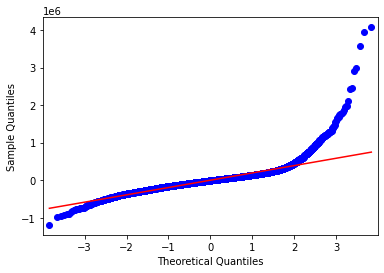

In [28]:
# QQ plots to check for normality; goes far off course in higher quantile
X_cols = [c for c in data_longzoom.columns.to_list() if c not in ['price', 'date']] 

X = data_longzoom[X_cols]
y = data_longzoom['price']

lr = LinearRegression()

lr.fit(X, y)

preds = lr.predict(X)

residuals = y-preds
fig = sm.qqplot(residuals, line = 'r')

In [29]:
high_corr(0.7, data_longzoom)
# 0.8 correlation is severe multi-collinearity - http://www.sfu.ca/~dsignori/buec333/lecture%2016.pdf
# Plenty of highly correlated features to address - sqft_living and sqft_above is severe and should be first priority

,level_0,level_1,0
22,price,sqft_living,0.703570
58,bathrooms,sqft_living,0.743494
73,sqft_living,price,0.703570
75,sqft_living,bathrooms,0.743494
81,sqft_living,grade,0.740156
82,sqft_living,sqft_above,0.858212
88,sqft_living,sqft_living15,0.717626
166,grade,sqft_living,0.740156
172,grade,sqft_above,0.730115
184,sqft_above,sqft_living,0.858212


## Before addressing multicollinearity/high correlations, look for and address outliers

In [30]:
# Descibe full data set to see any glaring outliers
data_longzoom.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.621400e+04,1.621400e+04,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000,16214.000000
mean,4.545986e+09,5.335436e+05,3.333169,2.029049,1971.582953,9514.380165,1.446620,0.007278,3.452695,7.523066,1646.579623,1965.249661,78.429074,98088.893672,47.567007,-122.278792,1875.384791,8541.404404
std,2.830427e+09,3.889760e+05,0.962320,0.773342,870.450928,17842.969808,0.547647,0.085001,0.675099,1.108744,746.344090,29.921309,387.861676,56.322623,0.136745,0.081437,618.795222,11885.730426
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,520.000000,1.000000,0.000000,1.000000,4.000000,370.000000,1900.000000,0.000000,98001.000000,47.257400,-122.519000,399.000000,651.000000
25%,2.172000e+09,3.100000e+05,3.000000,1.500000,1360.000000,4929.250000,1.000000,0.000000,3.000000,7.000000,1130.000000,1946.000000,0.000000,98034.000000,47.480425,-122.349000,1440.000000,5000.000000
50%,3.885802e+09,4.350000e+05,3.000000,2.000000,1810.000000,7265.500000,1.000000,0.000000,3.000000,7.000000,1440.000000,1965.000000,0.000000,98105.000000,47.577200,-122.292000,1750.000000,7350.000000
75%,7.212651e+09,6.230000e+05,4.000000,2.500000,2400.000000,9647.000000,2.000000,0.000000,4.000000,8.000000,1970.000000,1990.000000,0.000000,98125.000000,47.682875,-122.202000,2190.000000,9350.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,12050.000000,843309.000000,3.500000,1.000000,5.000000,13.000000,8860.000000,2015.000000,2015.000000,98199.000000,47.777600,-122.125000,5790.000000,380279.000000


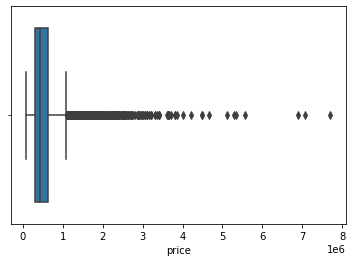

In [31]:
# Clear outlier in max price
sns.boxplot(data_longzoom['price'])
# 1.25 mil accounts for most

In [32]:
# Current shape
data_longzoom.shape

(16214, 20)

In [33]:
# How many records left when taking out outliers
data_longzoom[data_longzoom['price'] <= 1250000]['id'].count()

15474

In [34]:
(16214-15474)/16214
# 4% of data, but outliers will impact model success

0.04563957074133465

In [35]:
# Create "master variable" data_focused and filter out price outliers
data_focused = data_longzoom[data_longzoom['price'] <= 1250000]

In [36]:
# Bedrooms also had outliers
data_focused['bedrooms'].describe()

count    15474.000000
mean         3.294494
std          0.946613
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

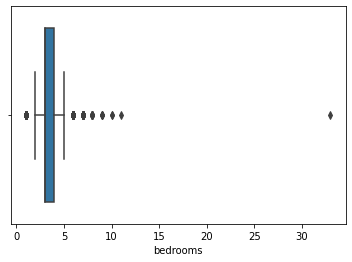

In [37]:
sns.boxplot(data_focused['bedrooms'])
# 1-5 bedrooms looks like where data is concentrated

In [38]:
# How many records in 1-5 bedroom range?
data_focused[(data_focused['bedrooms'] >=1) & (data_focused['bedrooms'] <=5)]['id'].count()

15231

In [39]:
(15474-15231)/15474
# Another 1% of data loss, but for betterment of model and concentration

0.015703761147731678

In [40]:
# Update master variable and dataframe
data_focused = data_focused[(data_focused['bedrooms'] >=1) & (data_focused['bedrooms'] <=5)]

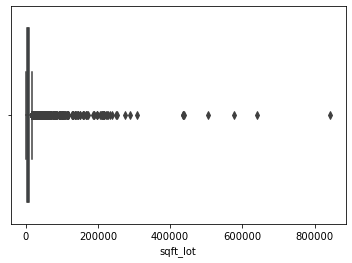

In [41]:
#Sqft_lot also had outliers
sns.boxplot(data_focused['sqft_lot'])

In [42]:
data_focused['sqft_lot'].describe()

count     15231.000000
mean       9236.394196
std       17938.694219
min         520.000000
25%        4800.000000
50%        7203.000000
75%        9506.500000
max      843309.000000
Name: sqft_lot, dtype: float64

In [43]:
# Many over the 75% mark, but few above 30000. Remove these
(data_focused['sqft_lot']>=30000).sum()

390

In [44]:
# Update master variable and dataframe
data_focused = data_focused[data_focused['sqft_lot']<30000]

In [45]:
# Check bathrooms since they have more detailed measurement and large range (in context of 5 bedroom houses)
data_focused.groupby(by='bathrooms')['id'].count()

bathrooms
0.50       4
0.75      47
1.00    3389
1.25       7
1.50    1230
1.75    2371
2.00    1465
2.25    1386
2.50    3056
2.75     721
3.00     470
3.25     257
3.50     327
3.75      48
4.00      33
4.25      15
4.50      13
4.75       1
5.00       1
Name: id, dtype: int64

In [46]:
# Create new column
data_focused['full_bath'] = 0

# For each value in data['bathrooms']
for row in data_focused['bathrooms'].index:
    if (data_focused['bathrooms'][row] <1):
        data_focused['full_bath'][row] = 0
    if (data_focused['bathrooms'][row] >=1) and (data_focused['bathrooms'][row] <2):
        data_focused['full_bath'][row] = 1
    if (data_focused['bathrooms'][row] >=2) and (data_focused['bathrooms'][row] <3):
        data_focused['full_bath'][row] = 2
    if (data_focused['bathrooms'][row] >=3) and (data_focused['bathrooms'][row] <4):
        data_focused['full_bath'][row] = 3
    if (data_focused['bathrooms'][row] >=4) and (data_focused['bathrooms'][row] <5):
        data_focused['full_bath'][row] = 4
    if (data_focused['bathrooms'][row] >=5) and (data_focused['bathrooms'][row] <6):
        data_focused['full_bath'][row] = 5

<ipython-input-46-2906f3bec1c4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_focused['full_bath'][row] = 1
<ipython-input-46-2906f3bec1c4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_focused['full_bath'][row] = 2
<ipython-input-46-2906f3bec1c4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_focused['full_bath'][row] = 3
<ipython-input-46-2906f3bec1c4>:7: SettingWithCopyWarning: 
A value is trying to be set o

In [47]:
data_focused.groupby(by='full_bath')['id'].count()

full_bath
0      51
1    6997
2    6628
3    1102
4      62
5       1
Name: id, dtype: int64

In [48]:
# Majority of data is between 1 and 3 baths
data_focused[(data_focused['full_bath']>0) & (data_focused['full_bath']<4)]['id'].count()

14727

In [49]:
(15223-15096)/15223
# Less than 1% loss in removing outliers

0.008342639427182552

In [50]:
# Update master variable
data_focused = data_focused[(data_focused['full_bath']>0) & (data_focused['full_bath']<4)]

In [51]:
# Update master variable and drop bathroom
data_focused = data_focused.drop(labels='bathrooms', axis=1)

In [52]:
data_focused.info()
# homes with price <= $1.25 million, 1-5 bedrooms, 1-3 bathrooms (full_bath), smaller geographical area

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14727 entries, 0 to 21593
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             14727 non-null  int64         
 1   date           14727 non-null  datetime64[ns]
 2   price          14727 non-null  float64       
 3   bedrooms       14727 non-null  int64         
 4   sqft_living    14727 non-null  int64         
 5   sqft_lot       14727 non-null  int64         
 6   floors         14727 non-null  float64       
 7   waterfront     14727 non-null  float64       
 8   condition      14727 non-null  int64         
 9   grade          14727 non-null  int64         
 10  sqft_above     14727 non-null  int64         
 11  sqft_basement  14727 non-null  object        
 12  yr_built       14727 non-null  int64         
 13  yr_renovated   14727 non-null  int64         
 14  zipcode        14727 non-null  int64         
 15  lat            1472

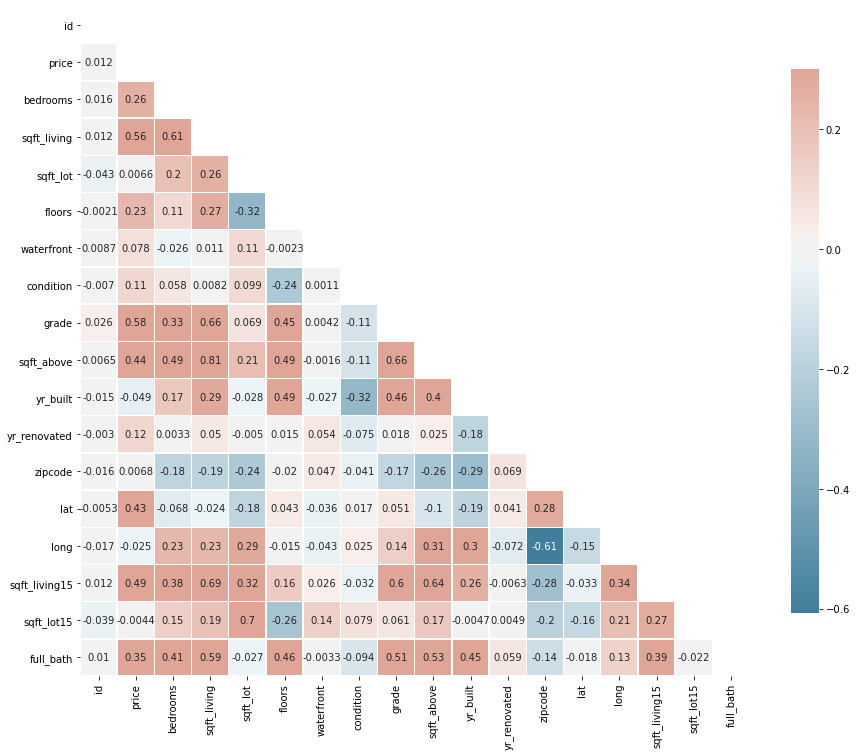

In [53]:
correlation_view(data_focused, annot=True)

In [54]:
high_corr(0.7, data_focused)
# Removing outliers addressed many of previously high correlation features
# sqft_above and sqft_living is still high at .8.
# Test without sqft_above as sqft_living has higher correlation with price

,level_0,level_1,0
63,sqft_living,sqft_above,0.80977
165,sqft_above,sqft_living,0.80977


# Model 3: Model without sqft_above

In [55]:
data_focused_nosfa = data_focused.drop(labels='sqft_above', axis=1)

In [56]:
model_scores(data_focused_nosfa, remove=['price', 'date', 'id'], target =['price'], testsize=0.33)
# R-squared down, but expected because of high correlation between the two
# Testing > Training so slightly underfit

Training Scores:
R2: 0.6700797327685774
Mean Absolute Error: 93379.26001991126
Root Mean Squared Error: 305.5802022708789
---
Testing Scores:
R2: 0.6807639551419107
Mean Absolute Error: 93135.83077384827
Root Mean Squared Error: 305.18163570871735


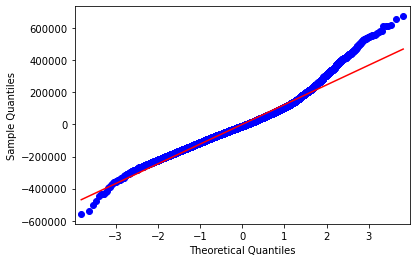

In [57]:
X_cols = [c for c in data_focused_nosfa.columns.to_list() if c not in ['price', 'date', 'id']] 

X = data_focused_nosfa[X_cols]
y = data_focused_nosfa['price']

lr = LinearRegression()

lr.fit(X, y)

preds = lr.predict(X)

residuals = y-preds
fig = sm.qqplot(residuals, line = 'r')
# qq plot strays at higher quantiles; 2 deviations from mean (outliers)

In [58]:
high_corr(0.7, data_focused_nosfa)
# Check back on correlations. None over 0.7 now.

,level_0,level_1,0


In [59]:
# Reassign master variable
data_focused = data_focused_nosfa

## Additional Feature Engineering and Replacement

In [60]:
data_focused[data_focused['sqft_basement']==0]['id'].count()
# Nearly half of dataset doesn't have basement

8331

In [61]:
# has_basement instead of sqft_basement
data_focused['has_basement'] = 0

for row in data_focused['sqft_basement'].index:
    if (data_focused['sqft_basement'][row] > 0.0):
        data_focused['has_basement'][row] = 1
    else:
        data_focused['has_basement'][row] = 0

<ipython-input-61-5ccd98e65a3f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_focused['has_basement'][row] = 0
<ipython-input-61-5ccd98e65a3f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_focused['has_basement'][row] = 1


In [62]:
data_focused[data_focused['yr_renovated']==0]['id'].count()
# Most homes haven't been renovated

14231

In [63]:
# Create new column for Boolean has_been_renovated
data_focused['has_been_renovated'] = 0

# For each value in data['yr_renovated'], if 0 put 0 in has_been_renovated; 1 if it has other values
for row in data_focused['yr_renovated'].index:
    if data_focused['yr_renovated'][row] == 0:
        data_focused['has_been_renovated'][row] = 0
    elif data_focused['yr_renovated'][row] > 0:
        data_focused['has_been_renovated'][row] = 1

<ipython-input-63-e1927eecb0d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_focused['has_been_renovated'][row] = 0
<ipython-input-63-e1927eecb0d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_focused['has_been_renovated'][row] = 1


In [64]:
# Update master variable and drop replaced columns ()
data_focused = data_focused.drop(labels=['sqft_basement', 'yr_renovated'], axis=1)

In [65]:
data_focused.columns

Index(['id', 'date', 'price', 'bedrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'yr_built', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'full_bath', 'has_basement',
       'has_been_renovated'],
      dtype='object')

In [66]:
data_focused.head()

,id,date,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,full_bath,has_basement,has_been_renovated
0,7129300520,2014-10-13,221900.0,3,1180,5650,1.0,0.0,3,7,1955,98178,47.5112,-122.257,1340,5650,1,0,0
1,6414100192,2014-12-09,538000.0,3,2570,7242,2.0,0.0,3,7,1951,98125,47.7210,-122.319,1690,7639,2,1,1
2,5631500400,2015-02-25,180000.0,2,770,10000,1.0,0.0,3,6,1933,98028,47.7379,-122.233,2720,8062,1,0,0
3,2487200875,2014-12-09,604000.0,4,1960,5000,1.0,0.0,5,7,1965,98136,47.5208,-122.393,1360,5000,3,1,0
6,1321400060,2014-06-27,257500.0,3,1715,6819,2.0,0.0,3,7,1995,98003,47.3097,-122.327,2238,6819,2,0,0


In [67]:
# Create age from yr_built
data_focused['age'] = 0

In [68]:
# Also need year of sale for age
data_focused['yr_of_sale'] = pd.DatetimeIndex(data_focused['date']).year

In [69]:
# Check work
data_focused['yr_of_sale'].head()

0    2014
1    2014
2    2015
3    2014
6    2014
Name: yr_of_sale, dtype: int64

In [70]:
for row in data_focused['age'].index:
    data_focused['age'][row] = data_focused['yr_of_sale'][row] - data_focused['yr_built'][row]

<ipython-input-70-59e13b09e762>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_focused['age'][row] = data_focused['yr_of_sale'][row] - data_focused['yr_built'][row]


In [71]:
data_focused['age'].describe()
# min is -1 need to take out negatives, data errors means sold before built

count    14727.000000
mean        49.278740
std         29.820287
min         -1.000000
25%         25.000000
50%         50.000000
75%         68.000000
max        115.000000
Name: age, dtype: float64

In [72]:
data_focused[data_focused['age'] <0]['id'].count()

11

In [73]:
data_focused = data_focused[data_focused['age'] >=0]

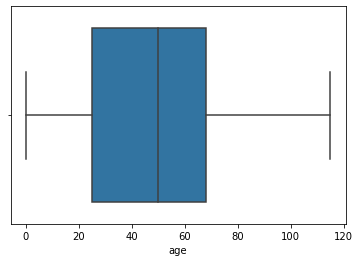

In [74]:
sns.boxplot(data_focused['age'])

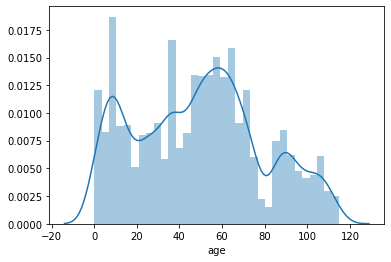

In [75]:
sns.distplot(data_focused['age'])

In [76]:
data_focused = data_focused[data_focused['age'] >=0]

In [77]:
# Take out columns used to assist in building this feature - would contribute to multicollinearity
data_focused = data_focused.drop(labels=['yr_of_sale', 'yr_built'], axis=1)

In [78]:
data_focused.columns

Index(['id', 'date', 'price', 'bedrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'full_bath', 'has_basement',
       'has_been_renovated', 'age'],
      dtype='object')

## Model 4: New Features and Booleans

In [79]:
model_scores(data_focused, remove=['price', 'date', 'id'], target =['price'], testsize=0.33)
# R-squared slightly up and data simplified
# Testing > Training so slightly underfit

Training Scores:
R2: 0.6719763538346077
Mean Absolute Error: 92948.69295012558
Root Mean Squared Error: 304.87488081199075
---
Testing Scores:
R2: 0.6811671262303157
Mean Absolute Error: 93117.54588250273
Root Mean Squared Error: 305.15167684694563


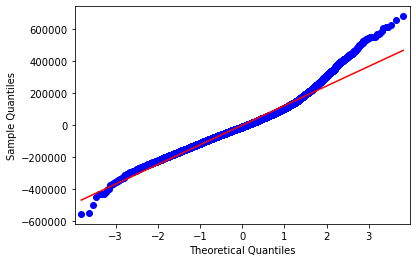

In [80]:
X_cols = [c for c in data_focused.columns.to_list() if c not in ['price', 'date', 'id']] 

X = data_focused[X_cols]
y = data_focused['price']

lr = LinearRegression()

lr.fit(X, y)

preds = lr.predict(X)

residuals = y-preds
fig = sm.qqplot(residuals, line = 'r')
# similar qq plot, straying at 2 deviations from mean

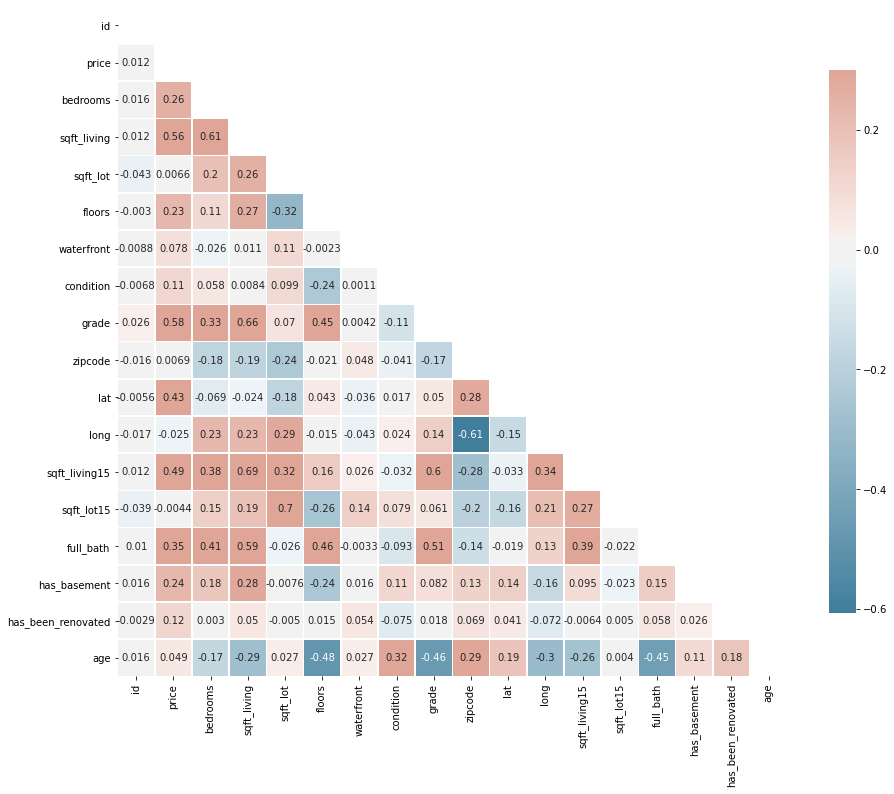

In [81]:
correlation_view(data_focused, annot=True)

In [82]:
# Nothing over 0.7, checking 0.6 as thresh
high_corr(0.6, data_focused)
# Sqft_lot15 has high correlation with sqft_lot. Sqft_lot has slightly higher correlation with price and
# is related to the specific property versus the area. Test without sqft_lot15

,level_0,level_1,0
39,bedrooms,sqft_living,0.612915
56,sqft_living,bedrooms,0.612915
62,sqft_living,grade,0.660963
66,sqft_living,sqft_living15,0.685718
85,sqft_lot,sqft_lot15,0.699094
147,grade,sqft_living,0.660963
156,grade,sqft_living15,0.603016
219,sqft_living15,sqft_living,0.685718
224,sqft_living15,grade,0.603016
238,sqft_lot15,sqft_lot,0.699094


# Model 5: Testing without sqft_lot15

In [83]:
data_focused_nolot15_test = data_focused.drop(labels='sqft_lot15', axis=1)

In [84]:
model_scores(data_focused_nolot15_test, remove=['price', 'date', 'id'], target =['price'], testsize=0.33)
# R-squared same - Keep sqft_lot15 off
# Testing > Training so slightly underfit

Training Scores:
R2: 0.6717245608643047
Mean Absolute Error: 92979.97600633206
Root Mean Squared Error: 304.9261812411851
---
Testing Scores:
R2: 0.6806957329948243
Mean Absolute Error: 93162.86933785827
Root Mean Squared Error: 305.2259316274721


In [85]:
# Reassign master variable
data_focused = data_focused_nolot15_test

In [86]:
data_focused.columns

Index(['id', 'date', 'price', 'bedrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'zipcode', 'lat', 'long',
       'sqft_living15', 'full_bath', 'has_basement', 'has_been_renovated',
       'age'],
      dtype='object')

In [87]:
# Nothing over 0.7, checking 0.6 as thresh
high_corr(0.6, data_focused)
# Sqft_living15 has high correlation with sqft_living. Sqft_living has slightly higher correlation with price and
# is related to the specific property versus the area. Test without sqft_living15

,level_0,level_1,0
37,bedrooms,sqft_living,0.612915
53,sqft_living,bedrooms,0.612915
59,sqft_living,grade,0.660963
63,sqft_living,sqft_living15,0.685718
139,grade,sqft_living,0.660963
148,grade,sqft_living15,0.603016
207,sqft_living15,sqft_living,0.685718
212,sqft_living15,grade,0.603016


# Model 6: Testing without sqft_living15

In [88]:
# Sqft_living15 also had high correlaton with sqft_living, test without
data_focused_noliv15_test = data_focused.drop(labels='sqft_living15', axis=1)

In [89]:
model_scores(data_focused_noliv15_test, remove=['price', 'date', 'id'], target =['price'], testsize=0.33)
# R-squared down, but expected - need to rid of highly correlated variables that measure similar things
# Testing > Training so slightly underfit

Training Scores:
R2: 0.6583247058270081
Mean Absolute Error: 94555.59902604343
Root Mean Squared Error: 307.4989415039399
---
Testing Scores:
R2: 0.6685014107548821
Mean Absolute Error: 94771.59776177388
Root Mean Squared Error: 307.84995982097166


In [90]:
# Reassign master variable
data_focused = data_focused_noliv15_test

In [91]:
data_focused.columns

Index(['id', 'date', 'price', 'bedrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'zipcode', 'lat', 'long',
       'full_bath', 'has_basement', 'has_been_renovated', 'age'],
      dtype='object')

In [92]:
# Nothing over 0.7, checking 0.6 as thresh
high_corr(0.6, data_focused)
# Down to only 2 correlations - bedrooms and sqft_living / sqft_living and grade
# Will move on to additional levers and come back if needed.

,level_0,level_1,0
35,bedrooms,sqft_living,0.612915
50,sqft_living,bedrooms,0.612915
56,sqft_living,grade,0.660963
131,grade,sqft_living,0.660963


## Log transform continuous variables

In [93]:
continuous = ['price', 'sqft_living', 'sqft_lot']
# categorical = ['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'zipcode',
#                'lat', 'long', 'full_bath', 'has_basement', 'has_been_renovated']
# remove = ['id', 'date']

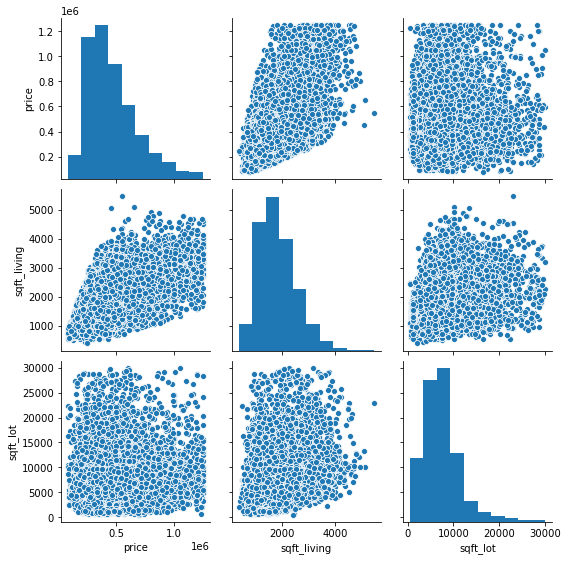

In [94]:
# View distributions
sns.pairplot(data_focused[continuous])
# continuous are skewed left

In [95]:
# continuous are skewed left, log transform
data_focused_cont = data_focused[continuous]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4072540a0>,
      dtype=object)

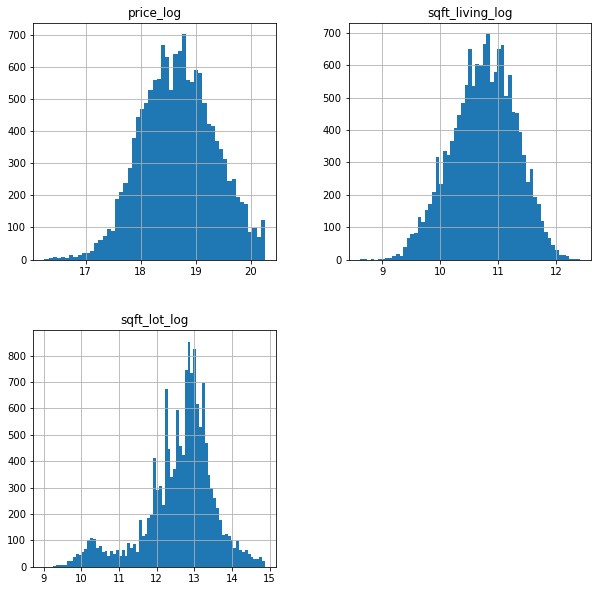

In [96]:
#  Create new columns with "_log" for log transformed values
log_names = [f'{column}_log' for column in data_focused_cont.columns] 

# Log transform, create a new table with log_names as column names, plot new values
data_focused_log = np.log2(data_focused_cont)
data_focused_log.columns = log_names
data_focused_log.hist(figsize=(10, 10), bins='auto')

In [97]:
# Preview table
data_focused_log

,price_log,sqft_living_log,sqft_lot_log
0,17.759550,10.204571,12.464035
1,19.037247,11.327553,12.822172
2,17.457637,9.588715,13.287712
3,19.204189,10.936638,12.287712
6,17.974213,10.743993,12.735344
...,...,...,...
21589,19.220069,11.299208,12.556267
21590,19.945924,11.777255,12.813781
21591,18.857568,10.355351,10.337622
21592,18.457637,10.579316,10.143383


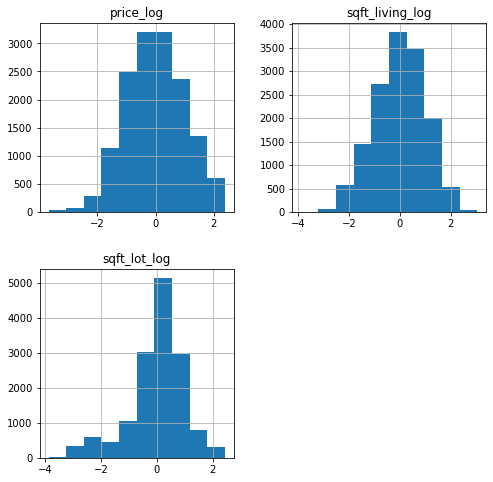

In [98]:
# Standardize the continuous variables
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

features_final = data_focused_log.apply(normalize)

features_final.hist(figsize  = [8, 8]);

In [99]:
# Create new table with logs replacing original columns and values
data_focused_with_logs = pd.concat([data_focused, features_final],axis=1)
data_focused_with_logs = data_focused_with_logs.drop(labels=['price', 'sqft_living', 'sqft_lot'], axis=1)

In [100]:
data_focused_with_logs.columns

Index(['id', 'date', 'bedrooms', 'floors', 'waterfront', 'condition', 'grade',
       'zipcode', 'lat', 'long', 'full_bath', 'has_basement',
       'has_been_renovated', 'age', 'price_log', 'sqft_living_log',
       'sqft_lot_log'],
      dtype='object')

# Model 7: Post Log-Transform

In [101]:
model_scores(data_focused_with_logs, remove=['price_log', 'date', 'id'], target =['price_log'], testsize=0.33)
# R-squared +3, and back to around original scoring (slightly above); Testing > Training so slightly underfit

Training Scores:
R2: 0.6996658354154783
Mean Absolute Error: 0.4251052074670418
Root Mean Squared Error: 0.6520009259710002
---
Testing Scores:
R2: 0.7050319202103128
Mean Absolute Error: 0.4257111862318204
Root Mean Squared Error: 0.6524654674630838


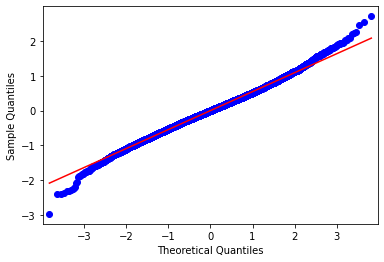

In [102]:
X_cols = [c for c in data_focused_with_logs.columns.to_list() if c not in ['price_log', 'date', 'id']] 

X = data_focused_with_logs[X_cols]
y = data_focused_with_logs['price_log']

lr = LinearRegression()

lr.fit(X, y)

preds = lr.predict(X)

residuals = y-preds
fig = sm.qqplot(residuals, line = 'r')
# qqplot line MASSIVELY improved, outliers ~3 deviations from mean impacted

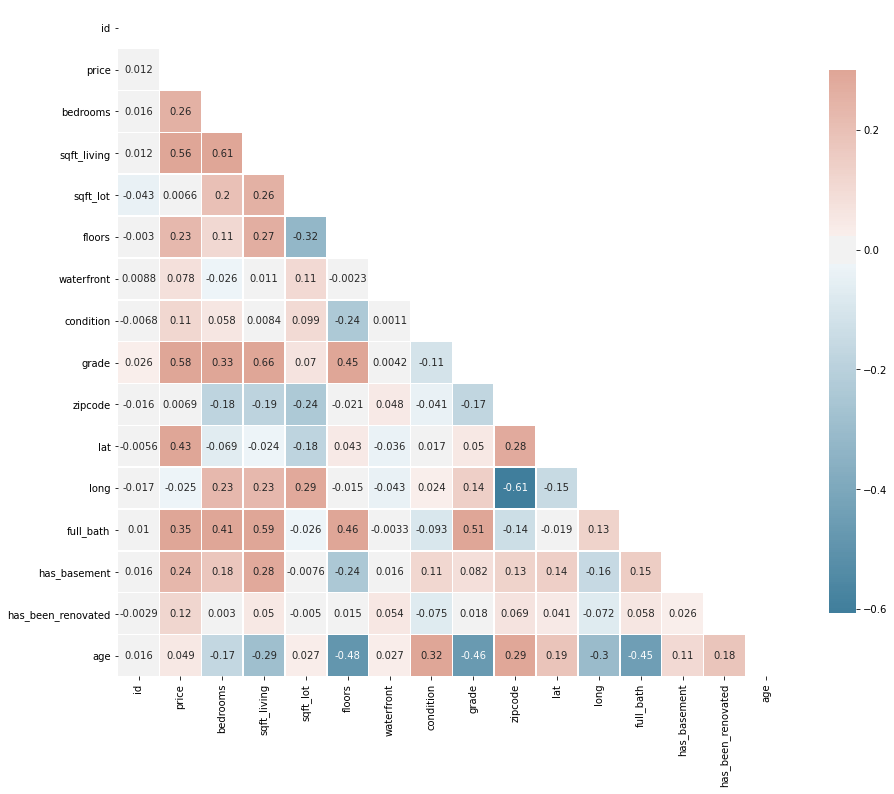

In [103]:
correlation_view(data_focused, annot=True)
# added has_basement and see it is positively correlated, but very low. Maybe we don't need it

In [104]:
# Update master variable
data_focused = data_focused_with_logs

# Model 8: Testing without has_basement

In [105]:
data_focused_noHB_test = data_focused.drop(labels='has_basement', axis=1)

In [106]:
model_scores(data_focused_noHB_test, remove=['price_log', 'date', 'id'], target =['price_log'], testsize=0.33)
# R-squared same - Keep has_basement off
# Testing > Training so slightly underfit

Training Scores:
R2: 0.6994472398751344
Mean Absolute Error: 0.4252727163017271
Root Mean Squared Error: 0.65212937083199
---
Testing Scores:
R2: 0.7051629471746974
Mean Absolute Error: 0.4257032879085991
Root Mean Squared Error: 0.6524594147597221


In [107]:
# Reassign master variable
data_focused = data_focused_noHB_test

In [108]:
data_focused.columns

Index(['id', 'date', 'bedrooms', 'floors', 'waterfront', 'condition', 'grade',
       'zipcode', 'lat', 'long', 'full_bath', 'has_been_renovated', 'age',
       'price_log', 'sqft_living_log', 'sqft_lot_log'],
      dtype='object')

In [109]:
# Look into zipcodes
set(data_focused['zipcode'])

{98001,
 98002,
 98003,
 98004,
 98005,
 98006,
 98007,
 98008,
 98011,
 98023,
 98027,
 98028,
 98030,
 98031,
 98032,
 98033,
 98034,
 98039,
 98040,
 98042,
 98052,
 98055,
 98056,
 98058,
 98059,
 98070,
 98072,
 98092,
 98102,
 98103,
 98105,
 98106,
 98107,
 98108,
 98109,
 98112,
 98115,
 98116,
 98117,
 98118,
 98119,
 98122,
 98125,
 98126,
 98133,
 98136,
 98144,
 98146,
 98148,
 98155,
 98166,
 98168,
 98177,
 98178,
 98188,
 98198,
 98199}

# Model 9: OHE zipcode

In [110]:
cat_cols = ['zipcode']

In [111]:
data_focused_zipohe = pd.get_dummies(data_focused, columns=cat_cols)

In [112]:
data_focused_zipohe.head()

,id,date,bedrooms,floors,waterfront,condition,grade,lat,long,full_bath,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,7129300520,2014-10-13,3,1.0,0.0,3,7,47.5112,-122.257,1,...,0,0,0,0,0,0,1,0,0,0
1,6414100192,2014-12-09,3,2.0,0.0,3,7,47.7210,-122.319,2,...,0,0,0,0,0,0,0,0,0,0
2,5631500400,2015-02-25,2,1.0,0.0,3,6,47.7379,-122.233,1,...,0,0,0,0,0,0,0,0,0,0
3,2487200875,2014-12-09,4,1.0,0.0,5,7,47.5208,-122.393,3,...,0,0,0,0,0,0,0,0,0,0
6,1321400060,2014-06-27,3,2.0,0.0,3,7,47.3097,-122.327,2,...,0,0,0,0,0,0,0,0,0,0


In [113]:
len(list(data_focused_zipohe.columns))

72

In [114]:
model_scores(data_focused_zipohe, remove=['price_log', 'date', 'id'], target =['price_log'], testsize=0.33)
# R-squared from 0.70 to .83; Also much higher versus categorized zipcode test at 0.75
# Training and Test score are extremely close - if anything very slightly overfit with Training .002 > Testing
# MSE and RMSE trending down from .425 and .652

Training Scores:
R2: 0.8353412156917217
Mean Absolute Error: 0.3007113787639668
Root Mean Squared Error: 0.5483715699814924
---
Testing Scores:
R2: 0.8378897614494859
Mean Absolute Error: 0.30109098781013977
Root Mean Squared Error: 0.5487175847465978


In [115]:
high_corr(0.6, data_focused_zipohe)
# No additional high correlation variables

,level_0,level_1,0
83,bedrooms,sqft_living_log,0.645531
367,grade,sqft_living_log,0.650787
853,sqft_living_log,bedrooms,0.645531
857,sqft_living_log,grade,0.650787


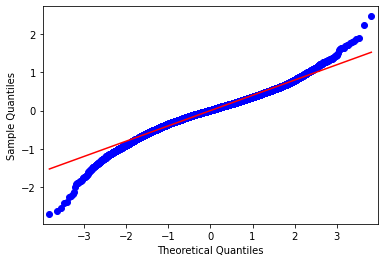

In [116]:
X_cols = [c for c in data_focused_zipohe.columns.to_list() if c not in ['price_log', 'date', 'id']] 

X = data_focused_zipohe[X_cols]
y = data_focused_zipohe['price_log']

lr = LinearRegression()

lr.fit(X, y)

preds = lr.predict(X)

residuals = y-preds
fig = sm.qqplot(residuals, line = 'r')
# qqplot line drops off at lower quantiles

In [117]:
# Update master variable
data_focused = data_focused_zipohe

# Context note: 
Zipcode coefficients will help home buyer see which places positively and negatively impact price.
Home buyers can research other things about the areas they are interesting like schooling for future family

# Model 10: Apply Standard Scaler to data

In [118]:
model_scores_stanscale(data_focused, remove=['price_log', 'date', 'id'], target =['price_log'], testsize=0.33)

Training Scores:
R2: 0.8352144058222042
Mean Absolute Error: 0.30099967862709076
Root Mean Squared Error: 0.548634376089478
---
Testing Scores:
R2: -2.584940132523953e+22
Mean Absolute Error: 2326834606.240441
Root Mean Squared Error: 48237.27403409567


In [119]:
X.columns

Index(['bedrooms', 'floors', 'waterfront', 'condition', 'grade', 'lat', 'long',
       'full_bath', 'has_been_renovated', 'age', 'sqft_living_log',
       'sqft_lot_log', 'zipcode_98001', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007',
       'zipcode_98008', 'zipcode_98011', 'zipcode_98023', 'zipcode_98027',
       'zipcode_98028', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98052', 'zipcode_98055', 'zipcode_98056',
       'zipcode_98058', 'zipcode_98059', 'zipcode_98070', 'zipcode_98072',
       'zipcode_98092', 'zipcode_98102', 'zipcode_98103', 'zipcode_98105',
       'zipcode_98106', 'zipcode_98107', 'zipcode_98108', 'zipcode_98109',
       'zipcode_98112', 'zipcode_98115', 'zipcode_98116', 'zipcode_98117',
       'zipcode_98118', 'zipcode_98119', 'zipcode_98122', 'zipcode_98125',
       'zipcode_98126', 'zip

In [120]:
# look at the coefficients with the names of each col
var_coeff_dict = dict(zip(X.columns, lr.coef_))
var_coeff_dict

{'bedrooms': -0.031012673623157457,
 'floors': 0.04693763539934683,
 'waterfront': 1.3714882450073267,
 'condition': 0.10610003419199915,
 'grade': 0.26828094070818254,
 'lat': 0.5448666936901561,
 'long': -0.6847403695129184,
 'full_bath': 0.05101339785538095,
 'has_been_renovated': 0.12023603883276657,
 'age': 0.0015940046046071799,
 'sqft_living_log': 0.36004927299547357,
 'sqft_lot_log': 0.11418394394750264,
 'zipcode_98001': -0.9684994742743283,
 'zipcode_98002': -0.9328267541547998,
 'zipcode_98003': -0.9481061683774455,
 'zipcode_98004': 1.2384424467682198,
 'zipcode_98005': 0.5813520411869384,
 'zipcode_98006': 0.42260787400140876,
 'zipcode_98007': 0.36870375566524605,
 'zipcode_98008': 0.39684893424441364,
 'zipcode_98011': -0.14152213714212308,
 'zipcode_98023': -1.080366000388508,
 'zipcode_98027': 0.5986717491024309,
 'zipcode_98028': -0.2626769152831068,
 'zipcode_98030': -0.8095752576105487,
 'zipcode_98031': -0.7859198070946081,
 'zipcode_98032': -1.0832674816314936,
 '

In [121]:
# Create DataFrame for organization
var_coeff_df = pd.DataFrame.from_dict(dict(zip(X.columns, lr.coef_)), orient='index')

In [122]:
# Look for highest coefficients. What zipcodes drive price up?
# zipcode source: https://www.unitedstateszipcodes.org/98011/
var_coeff_df.sort_values(by=0, ascending=False).head(6)
# 98039: Medina
# 98004: Bellevue
# 98112: (Seattle: Mann|Central Area)
# 98109: (Seattle: Westlake|Cascade)
# 98102: (Seattle: Eastlake|Cascade)
# Medina, Bellevue and parts of Seattle are highest positive influencers of price

,0
zipcode_98039,1.581155
waterfront,1.371488
zipcode_98004,1.238442
zipcode_98112,0.993613
zipcode_98109,0.977294
zipcode_98102,0.951213


In [123]:
# Look at lowest coefficients. What zipcodes drive price down
var_coeff_df.sort_values(by=0).head(20)
# 98032: Kent
# 98023/98001/98003: Auburn
# 98168: Seattle (Burien, Seatac, Tukwila)
# Kent, Auburn are highest negative influencers of price

,0
zipcode_98032,-1.083267
zipcode_98023,-1.080366
zipcode_98001,-0.968499
zipcode_98003,-0.948106
zipcode_98168,-0.941575
zipcode_98002,-0.932827
zipcode_98092,-0.877635
zipcode_98198,-0.834397
zipcode_98188,-0.834145
zipcode_98030,-0.809575


In [124]:
# What areas are around mean influence?
var_coeff_df[var_coeff_df.columns[0]].mean()
# 98011: Bothell
# 98072: Woodinville

0.03288401687096281

In [125]:
# What areas are around median influence?
var_coeff_df[var_coeff_df.columns[0]].median()
# 98028: Bothell
# 98133: Shoreline
# 98030: Kent
# Bothell seems to be in both, slightly outside of Seattle (NE)

0.047462506889902056

In [126]:
lr.intercept_

-112.08325645457924

In [127]:
var_coeff_df.sort_values(by=0, ascending=False).head(60)
# Beyond zipcode waterfront is highest driver of price

,0
zipcode_98039,1.581155
waterfront,1.371488
zipcode_98004,1.238442
zipcode_98112,0.993613
zipcode_98109,0.977294
zipcode_98102,0.951213
zipcode_98119,0.941432
zipcode_98105,0.869336
zipcode_98040,0.833329
zipcode_98107,0.674956


In [128]:
var_coeff_df.sort_values(by=0, ascending=False).head(60)
# Beyond zipcode waterfront is highest driver of price 1.37
# Latitude (how far north or south) the home is also has an impact on price 0.54
# grade is next highest at 0.27

,0
zipcode_98039,1.581155
waterfront,1.371488
zipcode_98004,1.238442
zipcode_98112,0.993613
zipcode_98109,0.977294
zipcode_98102,0.951213
zipcode_98119,0.941432
zipcode_98105,0.869336
zipcode_98040,0.833329
zipcode_98107,0.674956


## Data Analysis

In [135]:
# 98039: Medina
# 98004: Bellevue
# 98112: (Seattle: Mann|Central Area)
# 98109: (Seattle: Westlake|Cascade)
# 98102: (Seattle: Eastlake|Cascade)
positive_zips = data_focused[(data_focused['zipcode_98039'] == 1) | (data_focused['zipcode_98004'] == 1) | 
             (data_focused['zipcode_98112'] == 1) | (data_focused['zipcode_98109'] == 1) |
             (data_focused['zipcode_98102'] == 1)]

In [136]:
negative_zips = data_focused[(data_focused['zipcode_98032'] == 1) | (data_focused['zipcode_98023'] == 1) | 
             (data_focused['zipcode_98001'] == 1) | (data_focused['zipcode_98003'] == 1) |
             (data_focused['zipcode_98168'] == 1)]
# 98032: Kent
# 98023/98001/98003: Auburn
# 98168: Seattle (Burien, Seatac, Tukwila)

In [138]:
positive_zips.columns

Index(['id', 'date', 'bedrooms', 'floors', 'waterfront', 'condition', 'grade',
       'lat', 'long', 'full_bath', 'has_been_renovated', 'age', 'price_log',
       'sqft_living_log', 'sqft_lot_log', 'zipcode_98001', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98011', 'zipcode_98023',
       'zipcode_98027', 'zipcode_98028', 'zipcode_98030', 'zipcode_98031',
       'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98052', 'zipcode_98055',
       'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98070',
       'zipcode_98072', 'zipcode_98092', 'zipcode_98102', 'zipcode_98103',
       'zipcode_98105', 'zipcode_98106', 'zipcode_98107', 'zipcode_98108',
       'zipcode_98109', 'zipcode_98112', 'zipcode_98115', 'zipcode_98116',
       'zipcode_98117', 'zipcode_98118', 'zipcode_98119', 'zipcode_98122',
       'zipcode_98

In [ ]:
negative_zips

In [131]:
# # Positive zips vs grade
# colordict = {1: 'red', 2: 'red', 3: 'red', 4: 'red',
#             5: 'red', 6: 'orange', 7: 'orange', 8: 'orange',
#             9: 'orange', 10: 'green', 11: 'green', 12: 'green',
#             13: 'green'}
# for lat, lon, grade in zip(positive_zips['lat'], positive_zips['long'], positive_zips['grade']):
#     folium.CircleMarker(
#         [lat, lon],
#         radius=1,
#         weight=3,
#         popup = grade,
#         color=colordict[grade],
#         key_on = grade,
#         fill=True,
#         fill_opacity=0.7
#         ).add_to(this_map_zoom)
# this_map_zoom

In [132]:
# # Negative zips vs grade
# colordict = {1: 'red', 2: 'red', 3: 'red', 4: 'red',
#             5: 'red', 6: 'orange', 7: 'orange', 8: 'orange',
#             9: 'orange', 10: 'green', 11: 'green', 12: 'green',
#             13: 'green'}
# for lat, lon, grade in zip(negative_zips['lat'], negative_zips['long'], negative_zips['grade']):
#     folium.CircleMarker(
#         [lat, lon],
#         radius=1,
#         weight=3,
#         popup = grade,
#         color=colordict[grade],
#         key_on = grade,
#         fill=True,
#         fill_opacity=0.7
#         ).add_to(this_map_zoom)
# this_map_zoom

In [133]:
# # Positive zips vs condition
# colordict = {1: 'red', 2: 'red', 3: 'orange', 4: 'green', 5: 'green'}
# for lat, lon, condition in zip(positive_zips['lat'], positive_zips['long'], positive_zips['condition']):
#     folium.CircleMarker(
#         [lat, lon],
#         radius=1,
#         weight=3,
#         popup = condition,
#         color=colordict[condition],
#         key_on = grade,
#         fill=True,
#         fill_opacity=0.7
#         ).add_to(this_map_zoom)
# this_map_zoom

In [134]:
# # Negative zips vs grade
# colordict = {1: 'red', 2: 'red', 3: 'orange', 4: 'green', 5: 'green'}
# for lat, lon, condition in zip(negative_zips['lat'], negative_zips['long'], negative_zips['condition']):
#     folium.CircleMarker(
#         [lat, lon],
#         radius=1,
#         weight=3,
#         popup = condition,
#         color=colordict[condition],
#         key_on = grade,
#         fill=True,
#         fill_opacity=0.7
#         ).add_to(this_map_zoom)
# this_map_zoom